In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"))

# A Hierarchical Sensor Model in GenJAX<br/><small>Localization with an idealized map</small>


<hr style="height:2px">

## Content

- Intro
- Making a render function
- Making the model
  - Bayes3D sensor model
  - Localization model
- Posterior inference and MAP estimates
    - Part 1: Infering sensor parameters for a fixed pose
    - Part 2: MAP estimates for sensor parameters for perturbed pose
- Demos: Posterior explorer


<hr style="height:2px">

## Introduction

In this session, we will simplify our model and shift our focus to a single *isolated*  time step. Unlike the previous tutorials that assumed sampling the current pose $p$ from a motion model $\mathbb{P}(p \mid p',u)$ conditioned on a prior pose $p'$ and control input $u$, we will take a different approach here.

Instead of delving into modeling these updates, we will directly sample the target pose $p$. This involves potentially selecting a position around a user-defined target, or sampling uniformly over the environment. It's important to note that we are still working under the assumption that we have access to a (possibly idealized) map of the environment.

The high-level structure of the model is as follows:

1. Sample a pose, denoted as $p$.
3. Sample sensor model noise $\sigma$, sometimes referred to as *inlier tolerance*, and an *outlier probability* $\omega$.
2. Perform a deterministic raycasting operation to generate a reference measurement, denoted as $Y$.
3. Sample an observation, $X$, from a sensor model. This sampling is conditioned on both the reference measurement $Y$ and the specific sensor parameters $\sigma$ and $\omega$.

As you will see below, one notable distinction in this tutorial is the raycasting operation. Instead of a 2D raycaster, as in the other sessions, we will use a "lifted" 3D version of the map and integrate it into a 3D renderer, which can be invoked using a specified pose.

We will then delve into exploring various aspects of the model's posterior distribution $\mathbb{P}(p,\sigma, \omega \mid X)$:

1. Firstly, we will demonstrate that it is possible to accurately infer the sensor parameters from a sample when conditioned upon the actual pose.
2. Moving forward, we will introduce pose variations and analyze the Maximum A Posteriori (MAP) estimates of sensor parameters associated with each specific pose.
3. Finally, we present two interactive visualizations that enable you to explore through both the pose posterior and full posterior.


In [3]:
import jax
import jax.numpy as jnp
from   jax import jit, vmap
import bayes3d as b3d
import genjax
from   genjax import gen, choice_map, vector_choice_map
from   genjax._src.core.transforms.incremental import UnknownChange, NoChange, Diff
import matplotlib.pyplot as plt
from   matplotlib.collections import LineCollection
import numpy as np
import trimesh
from functools import partial

key = jax.random.PRNGKey(0)
console = genjax.pretty(show_locals=False)

## Making a render function 

**Environment Data (2D to 3D)**

Before we can define our model we need a simulated sensor, or renderer, and
a simulated environment to make measurements in. We start by loading a 2D environment and an array of poses and construct a 3D versions of those.

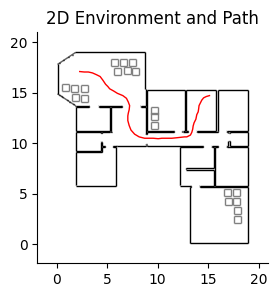

In [4]:
from xsight.utils import *
from xsight.importance import _importance_sampling, _update, _generate, _simulate, _propose
from xsight.pose import pack_pose, unpack_pose, apply_pose, from_euler, CAM_ALONG_X
from xsight.meshes import *
from xsight.plotting import *

#| Load environment data
#| `fname = "./data/test_env_2d_sym.json"`
fname = "./data/test_env_2d.json"
_segs, _boxes, _xs, _hds, _dxs, _dhds = unpack_2d_env_data(fname)
_verts  = _segs.reshape(-1,2)
_center = np.min(_verts, axis=0) + np.max(_verts, axis=0)/2
_T      = len(_xs)
_segs   = _segs.reshape(-1,2,2)
_boxes  = _boxes.reshape(-1,2,2)
_bb     = bounding_box(_segs)
_ps     = np.concatenate([_xs, _hds[:,None]], axis=1)

# ===============================
plt.figure(figsize=(3,3))
plt.title("2D Environment and Path")
ax = plt.gca()
ax.set_aspect(1)
zoom_in(_bb, 2, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plot_segs(_segs, c="k", zorder=1, ax=ax)
plot_segs(_boxes, c="gray", zorder=1, ax=ax)
ax.plot(*_ps[:,:2].T, c="r", linewidth=1);

In [5]:
#|  Create a 3d mesh from the 2d data and 
#|  create a scene for the renderer
box_mesh = trimesh.util.concatenate([trimesh_from_2d_segs(box) for box in _boxes.reshape(-1,4,4)])
map_mesh = trimesh_from_2d_segs(_segs.reshape(-1,4))
table = create_cuboid(20, 20, -0.1)
table = move_to_xy(table, *_center)
map_mesh.vertices[:,2] -= 0.5
box_mesh.vertices[:,2] -= 0.5
table.vertices[:,2]    -= 0.5

Here is a rendering of what we just created. But keep in mind that going forward 
we are forgetting about the 3D structure here. This is really just
so we can take advantage of the performance of the 3D renderer.

<img src="imgs/3denv.png" width=500/>

**3D Renderer**

Next, we will configure the renderer and incorporate the scene meshes, which include both the walls mesh and the box meshes. You'll notice that our goal is to render images with a height of 1, effectively emulating the output of a 2D lidar sensor. 

The render function takes a 3D Pose consisting of a tuple of a 3D rotation matrix and a translation vector.
But our poses `_ps` still live in 2D, so we have to *lift* them into our 3D scene.

In [6]:
def lift_pose(v, z=0.0, pitch=0.0, roll=0.0):
    """Lifts a 2d pose vector [x1,x2,hd] to 3d"""
    x  = v[:2]
    hd = v[ 2]
    return pack_pose(
        jnp.concatenate([x, jnp.array([z])]),
        from_euler(hd) @ CAM_ALONG_X
    ) 

The renderer also provides valuable semantic information (`Y[:,:,3]`) and specifies the source of each observation, indicating whether it originates from the walls or the boxes within the environment.

In [7]:
#| Set up the renderer and add the scene mesh, i.e. add the map mesh and the box meshes.
#| Note that we are rendering an image of height 1 mimicing a 2d lidar sensor.
def make_render_function(meshes, w=100, h=1, fx=30, fy =30):
    """
    Create a render function from a list of meshes 
    (and camera intrinsics).
    """
    intrinsics = b3d.Intrinsics(
        width = w, height = h,
        fx=fx, fy=fy,
        cx=w/2 - 0.5, cy=h/2 - 0.5,
        near=0.01, far=10.0
    )
    b3d.setup_renderer(intrinsics)
    for mesh in meshes:
        b3d.RENDERER.add_mesh(mesh, center_mesh=False)


    def render(p:"3D Pose", inds=[0,1]):
        """
        Render a rendered image from a fixed scene that this is closed over.
        The image is made up off 4 channels x,y,z, and
        a "semantic layer" containing object ids.
        """
        p_ = b3d.t3d.inverse_pose(p)
        X  = b3d.RENDERER.render(jnp.tile(p_, (len(inds),1,1)), jnp.array(inds))
        return X;

    return render

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (224, 128, 1024)


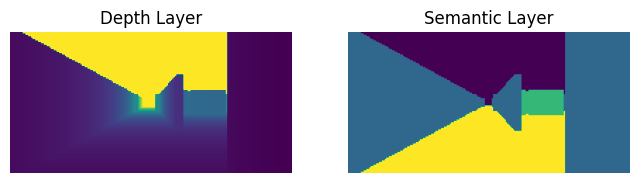

In [8]:
# Note that we actually can render a 3D image.
# However, as mentioned above we will only 
# render images of height 1 going forward 
render_3D = make_render_function([map_mesh, box_mesh, table], 
                              w=200, h=100, fx=50,fy=50)

t  = 15
p  = _ps[t]
Y  = render_3D(lift_pose(p), inds=[0,1,2])
# ======================
fig, axs = plt.subplots(1,2,figsize=(8,2))
for ax in axs: ax.axis("off")
axs[0].set_title("Depth Layer")
axs[0].imshow(Y[:,:,2], vmax=8.)
axs[1].set_title("Semantic Layer")
axs[1].imshow(Y[:,:,3])

In [9]:
# This (!) is the render function we are going to use 
# for the remainder of the notebooks
render = make_render_function([map_mesh, box_mesh, table], w=100, h=1);

Increasing frame buffer size to (width, height, depth) = (128, 32, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In our examples, we will consider the environment that includes the boxes as our designated simulated world. When we move on to inference, there's an option to exclude the boxes (`use_boxes:bool`), making the localization task less straightforward. 

As mentioned above a rendered image `Y` contains semantic information that caputures whether an observartions is from a wall `Y[i,j,3]==1` or a box `Y[i,j,3]==2`.

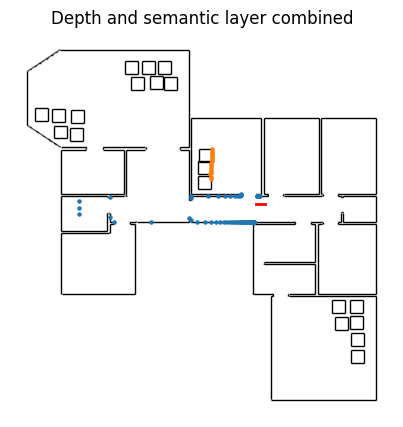

In [10]:
t  = 15 # Try `35` as well
p  = _ps[t]
Y  = render(lift_pose(p), inds=[0,1])
ys = Y[0,:,[0,2]].T
ys = apply_2dpose(p, ys)

# NOTE: The "semantic layer" should contain ints -- it's identities after all -- 
#   but the returned `dtype` of the image is `float64`. To avoid numerical issues
#   like having entries of the form `1.9999999` and not `2` we reduce the precision a bit  
is_outlier = Y[0,:,3].astype(jnp.float16) == 2

# ===========================
plt.figure(figsize=(5,5))
plt.gca().set_aspect(1)
plt.axis("off")
plt.title("Depth and semantic layer combined")
plot_segs(_segs, c="k", zorder=-1)
plot_segs(_boxes, c="k", zorder=-1)
plot_pose(_ps[t], ax=plt.gca())
plt.scatter(*ys[is_outlier==False].T, c="C0", s=5)
plt.scatter(*ys[is_outlier== True].T, c="C1", s=5)

In our examples, we will consider the environment that includes the boxes as our designated simulated world. When we move on to inference, there's an option to exclude the boxes, making the localization task less straightforward. As you will see in the example below it is quite possible for observation to have very high number (almost half) of outliers. This introduces the need to
- Equip the model with the capability to handle outliers flexibly, and 
- Do joint inference over pose and sensor paramters.

Knowing the number of measurements that come from boxes will be helpful to interpret and tune our model. Let's write a quick helper method to do that for us.



In [11]:
def inlier_vs_outlier_counts(t):
    """Deterministic inlier (walls) and outlier (boxes) counts."""
    p  = _ps[t]
    X  = render(lift_pose(p), inds=[0,1])
    return jnp.array([
        jnp.sum(X[0,:,3].astype(jnp.float16) == 1), 
        jnp.sum(X[0,:,3].astype(jnp.float16) == 2)])

In [12]:
# Blue -vs- Orange counts
inlier_vs_outlier_counts(35)

Array([42, 58], dtype=int32)

## Making the model

The last main ingredient for our localization model is a sensor model. We are not going to write that ourselves here &mdash; if you are interested in the detailed implementation check out the associated notebook `11 - Constrained Likelihood.ipynb`.

### Bayes3D Sensor Model


In [13]:
from genjax import tfp_uniform as uniform
from xsight.likelihood import make_constrained_sensor_model, make_baseline_sensor_model
from functools import lru_cache


def make_sensor_model(w:int, zmax:float, sensor_model_type:str="constrained"):
    """
    Returns a sensor model with given filter size `w` and maximal sensor range `zmax`.
    (The corresponding code can be found in `11 - Constrained Likelihood.ipynb`)
    """
    match sensor_model_type:
        case "constrained": return make_constrained_sensor_model(zmax, w)
        case "baseline"   : return make_baseline_sensor_model(zmax, w)
        case _: raise f"Unknown sensor model type: ``{sensor_model_type}''"

Let's "make" a sensor model and take a quick look at its signature and trace.

In [14]:
sensor_model = make_sensor_model(5, 10.)
help(sensor_model.source)

Help on function sensor_model in module xsight.likelihood:

sensor_model(Y, sig, outlier)
    Constrained sensor model that returns a vector of range measurements conditioned on 
    an image, noise level, and outlier probability.



In [15]:
t = 40  #`t=40`
args = Args(
    Y = render(lift_pose(_ps[t]), inds=[0,1])[:,:,:3],
    sig = 0.1,
    outlier = 0.0
)
key = keysplit(key)
tr  = sensor_model.simulate(key, args)

# ===================
# Take a look at `tr` on its own as well
display(tr.strip()) 

└── :X
    └── (Vector)
        └── :measurement
            └──  f32[100]

### Simple Localization Model

We finally have all the pieces to define our localization model.

In [16]:
def make_model(w:int, zmax:float, sensor_model_type:str="constrained"):

    #  Create a sensor model
    #  Note: We need to create a closure here becasue `w` is a *static* argument
    #       and needs to be handled in a special way for GenJAX not to 
    #       complain during JIT compilation. This pattern is similar to JAX's use 
    #       of `static_argnames` in `jit`. We are still working on the API.
    sensor_model = make_sensor_model(w, zmax, sensor_model_type)

    @gen
    def model(use_boxes):
        """Isolated time-step model that optionally renders the boxes or not. """

        #  Sample a 2D pose
        #  NOTE: The x bounds are roughly bounding the environment
        #  that is baked into the renderer
        x  = uniform(jnp.array([0., 0.]), 
                     jnp.array([20., 20.])) @ "x"
        hd = uniform(-jnp.pi, jnp.pi)       @ "hd"
        p  = pack_2dpose(x, hd)

        #  Sample sensor hyper parameters
        sig     = uniform(0.0, 1.) @ "sig"
        outlier = uniform(0.0, 1.) @ "outlier"

        #  Lift pose to 3D and 
        #  render an image (deterministic)
        inds = jnp.where(use_boxes, jnp.array([0,1]), jnp.array([0]))
        Y    = render(lift_pose(p), inds)

        #  Sample an image X conditioned on the rendered Y
        #  Here `inline` populates address `@ "X"`; cf. the way 
        #  the sensor model is structured. We don't have 
        #  syntactic sugar for this operation yet.
        X, _ = sensor_model.inline(Y[:,:,:3], sig, outlier) 

        # NOTE: Try and replace the above line 
        # by the line below and compare the traces 
        # X, _ = sensor_model(Y[:,:,:3], sig, outlier) @ "Sensor"
        
        return p, X
    
    return model

<hr style="height:2px">

**Q:** 
    
Looking at the model is there anything that stands out to you? (It is somewhat nitpicky.)

**A:**  
    
Note that we sample a head direction from a normal distribution. That part is fine, we just view the unit circle as the quotient `R/Z`, but if we were to evaluate a head direction under this model we would only evaluate the density at a single point, where in fact it would wrap around countably many times.

**Q:** 

Think about different versions of the model using the parts that we provided. Be creative. (Think about what the renderer provides as well.)

**EXCERCISE**: 
    
Write a distribution over the unit circle by "wrapping" a normal distribution around it. Alternatively just write down the logpdf.
<hr style="height:2px">

In [17]:
# TODO: Move to imports
def plot_tr(tr, ax=None, title="", size=10, c="r", c_data="C0", boxes=None):
    """Plot a trace of the Localization model."""
    
    if ax is None:
        plt.figure(figsize=(5,5))
        ax = plt.gca()

    use_boxes, = tr.args
    if boxes is not None: use_boxes = boxes
    p, X = tr.get_retval()
    xs = X[0][:,[0,2]]

    # ===============================
    if len(title) > 0: ax.set_title(f"{title}")
    ax.set_aspect(1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plot_segs(_segs, c="k", zorder=1, ax=ax)
    if use_boxes: plot_segs(_boxes, c="k", zorder=1, ax=ax)
    ax.scatter(*apply_2dpose(p, xs).T, s=size, zorder=2, c=c_data)
    plot_pose(p, r=.5, zorder=3,ax=ax, c=c)

Now, let's "make" a localization model and take a quick look at its signature and trace.
Feel free to switch the address structure in the model definition above (replacing the line containing `X, _ = sensor_model.inline(..)`) and take a look at how the trace structure changes.

In [18]:
w     = 0
zmax  = 10.0

model = make_model(w, zmax)
args  = Args(use_boxes=True) 
key   = keysplit(key)

# NOTE: `Args` is just my altered version of a named tuple.
# A Gen function consumes an n-tuple of arguments.
# The line could be replaced by `args = (True,)`.

tr = model.simulate(key, args)

# ========================================
display(tr.strip()) # Take a look at `tr` on its own as well

├── :X
│   └── (Vector)
│       └── :measurement
│           └──  f32[100]
├── :x
│   └──  f32[2]
├── :hd
│   └──  f32[]
├── :outlier
│   └──  f32[]
└── :sig
    └──  f32[]

Re-run the cell below multiple times to get a sense for the model traces.

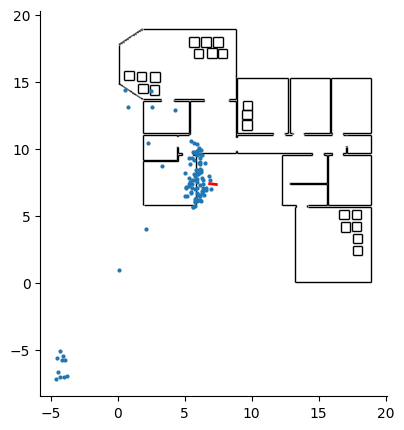

In [19]:
key = keysplit(key)
tr  = model.simulate(key, Args(use_boxes=True))
# =========================
plot_tr(tr, size=4)

In [20]:
def get_data_logprobs(tr):
    """Return individual log-probabilities of each observed pixel value."""
    pixel_addr = lambda i: genjax.select({"X":
        genjax.index_select(i,  genjax.select("measurement"))
    })
    inds  = jnp.arange(tr["X", "measurement"].shape[0])
    logps = vmap(lambda i: tr.project(pixel_addr(i)))(inds)
    return logps

<hr style="height:2px">

**EXCERCISE**: 

Use `get_data_logprobs` from above and highlight the observations in a trace that would be considered outliers.


**EXCERCISE**: 

Place the agent in a room with boxes. Make sure the sensor captures some of the boxes. This serves as our groundtruth. Then condition on the observation and use importance sampling to get a sense for the posterior. (Use `importance` and `vmap`)

Next, switch off the boxes, and note what happens to the probability scores. (Use `update` and `vmap`)
<hr style="height:2px">

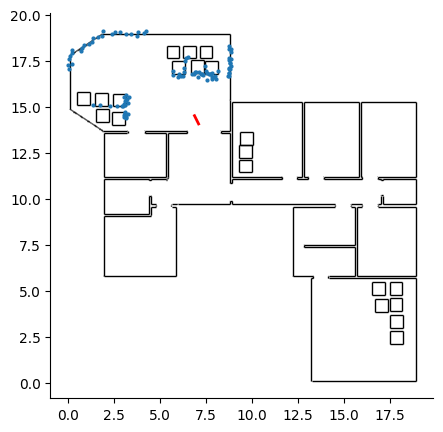

In [21]:
# NOTE: Switch `use_boxes` to `False`, and place the agent in a room with boxes. 
# Compare the scores in both cases. Play with the outlier prob and 
# incoroporate the counts computed above. What is happening, what does this imply? 

w     = 0
zmax  = 10.0
model = make_model(w, zmax)
key, keys = keysplit(key, 1, 2)

# Create ground truth
ch0 = choice_map({
        'x':  _ps[35][:2],
        'hd': _ps[35][ 2],
        'sig':     0.1,
        'outlier': 0.0 
})
w0, tr0 = model.importance(keys[0], ch0, Args(use_boxes=True))

# ====================
plot_tr(tr0, size=4)

In [22]:
# Change args and outlier prob and see how the scores change
ch1 = tr0.strip()
ch1["outlier"] = 0.0; # Try 0.1, 0.5
w1, tr1 = model.importance(keys[1], ch1, Args(use_boxes=False))
# ========================================
console.print(f"""
Scores with and without boxes
and outlier prob {ch0["outlier"]} and {ch1["outlier"]}:
 
tr0.score: {tr0.score:0.2f} 
tr1.score: {tr1.score:0.2f} 
""")

Scores with and without boxes
and outlier prob 0.0 and 0.0:
 
tr0.score: 68.50 
tr1.score: -18258.23

### Create Ground Truth

In our experiments we frequently have to create some ground truth sample.
So it makes sense to write a sampler for that and have it "jitted"; this is where GenJAX can showcase one of its strength: JAX-enabled GPU acceleration.

In [23]:
def make_ground_truth_sampler(w=5, zmax=10.0):

    # Use the constrained model because to 
    # get perturbations along each ray.
    model = make_model(w, zmax, "constrained")

    def sampler(key, p, sig, out, use_boxes):
        args  = (use_boxes,)
        _, tr = model.importance(key, genjax.choice_map({
            "x":  p[:2],
            "hd": adjust_angle(p[2]),
            "sig":     sig, 
            "outlier": out}), args) 
        return tr

    # Jit for optimized performance
    return jit(sampler)


create_ground_truth = make_ground_truth_sampler(w=5, zmax=10.0)

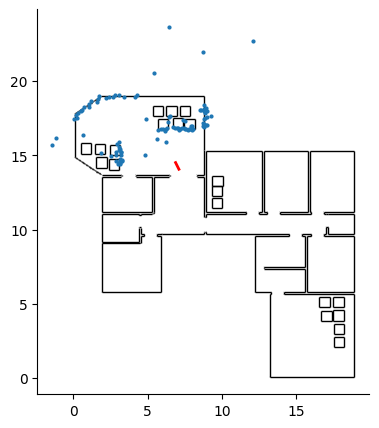

In [24]:
t0 = 35

p0        = _ps[t0]
sig0      = 1e-1
out0      = 0.1
use_boxes = True

key = keysplit(key)
tr0 = create_ground_truth(key, p0, sig0, out0, use_boxes)
# ====================
plot_tr(tr0, size=4)

<hr style="height:2px">

**EXCERCISE**: 

Make an un-jitted version of the sampler and compare the runtimes of both version.

```python
%timeit -n 1 -r 1 create_ground_truth(...)
%timeit -n 1 -r 1 unjitted_create_ground_truth(...)
```

<hr style="height:2px">

### Vector Grid

In [25]:
def get_linear_grid(shape, bounds, flat=False):
    """Create a (linear) grid of a given shape and bounds."""
    
    linspaces = [jnp.linspace(*b, d) for b,d in zip(bounds, shape)]
    vs = jnp.stack(jnp.meshgrid(*linspaces, indexing='ij'), axis=-1)
    if flat: vs = vs.reshape(-1,len(shape))
    
    return vs

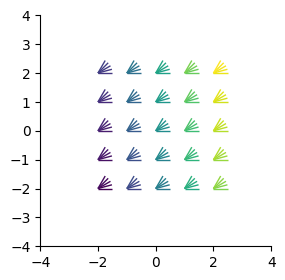

In [26]:
vs = get_linear_grid((5, 5, 5), ((-2,2), (-2,2), (0,jnp.pi/3)), flat=True)
sc = jnp.arange(len(vs))

# =======================================
fig, ax = plt.subplots(1,1,figsize=(3,3))
zoom_in(vs[:,:2], 2, ax=ax)
plot_poses(vs, sc, linewidth=1, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

let's start slow and consider $\mathbb{P}(\sigma, \omega \mid p_0, X_0)$ where 

## Posterior inference

### Part 1: Infering sensor parameters for a fixed pose

As a warm up, before we analyse the full posterior, 
we consider a sample $(\sigma_0, \omega_0, p_0, X_0) \sim \mathbb{P}_{\text{model}}$ from our model 
and examine $\mathbb{P}(\sigma, \omega \mid p_0, X_0)$. Particularly we 
want to check if we can indeed infer $\sigma_0, \omega_0$.

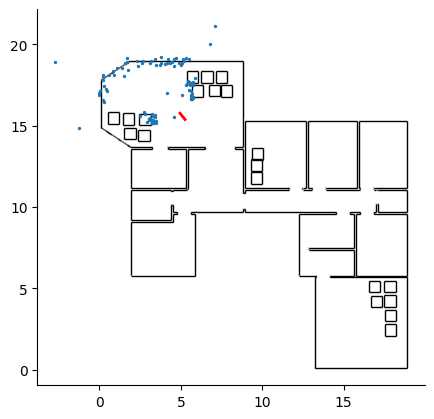

In [27]:
key  = keysplit(key)
t0   = 40
p0   = _ps[t0]
sig0 = 0.2
out0 = 0.1

tr0  = create_ground_truth(key, p0, sig0, out0, use_boxes=True)

# ====================
plot_tr(tr0, size=2)

<hr style="height:2px">

**EXCERCISE**: 

Compute and look at the posterior over sensor parameter, ie. `sig` and `outlier`, conditioned on the remaining choices from the trace above, ie. `p0` and `X0`. Use `vmap` and `jit`, and the `get_linear_grid` method from above. Assess if the model infers the right sensor parameters.

```python
def eval_sensor_posterior(tr, shape, bounds)
    assert len(shape) == len(bounds) == 2
    
    # Your code 
    # ...
        
    return grid, scores
```

Next write a version that only returns the MAP estimates

```python
def sensor_MAP_estimate(tr, shape, bounds)
    assert len(shape) == len(bounds) == 2
    
    # Your code 
    # ...
        
    return sig_map, out_map, score_map
```

<hr style="height:2px">

There a couple of ways to achieve this, here's our solution.

In [28]:
def _eval_sensor_posterior(key, tr, use_boxes, sig, out):
    ch   = choice_map({'sig': sig, 'outlier': out})
    args = (use_boxes,)
    (_, _, tr_, _) = tr.update(key, ch, argdiffs(args))
    return tr_.get_score()

# Generally it is useful to keep un-jitted versions
# of the functions around. Typically in JAX it is recommended
# to jit the at the end, and not at intermediate steps. Later
# we reuse some of those functions.
mapped_eval_sensor_posterior = jax.vmap(_eval_sensor_posterior, (None, None, None, 0, 0))
eval_sensor_posterior = jax.jit(mapped_eval_sensor_posterior)

In [29]:
def _sensor_MAP_estimate(key, tr, sigs, outls, use_boxes=True):
    key = keysplit(key)
    scores = mapped_eval_sensor_posterior(key, tr, use_boxes, sigs, outls)
    i_map  = jnp.argmax(scores)

    return sigs[i_map], outls[i_map], scores[i_map]


mapped_sensor_MAP_estimate = jax.vmap(_sensor_MAP_estimate, (None, 0, None, None, None))
sensor_MAP_estimate = jax.jit(mapped_sensor_MAP_estimate)

In [30]:
shape  = (10,10)
bounds = ((0.05, 1.), (1e-2, .9))
grid = get_linear_grid(shape, bounds, flat=True)
sigs  = grid[...,0]
outls = grid[...,1]

use_boxes = True

sig_map, out_map, _ = _sensor_MAP_estimate(key, tr0, sigs, outls, use_boxes=True)
# ==================
console.print(f"""
MAP Inference:

    sigma:   {sig_map:0.2f}  ({sig0:0.2f})
    outlier: {out_map:0.2f}  ({out0:0.2f})
""")

MAP Inference:

    sigma:   0.16  (0.20)
    outlier: 0.11  (0.10)

<hr style="height:2px">

**EXCERCISE**: 

Use `get_data_logprobs` from above and color the observations in `sensor_posterior_experiment` that would be considered outliers.

<hr style="height:2px">

### Posterior Examples: $\mathbb{P}(\sigma, \omega \mid p_0, X_0)$

We just confirmed that MAP inference works pretty well. Now we are taking a look at some examples of $\mathbb{P}(\sigma, \omega \mid p_0, X_0)$ and how it changes for different $\sigma_0, \omega_0$.

In [31]:
# TODO: Hide this cell or move to imports
# TODO: Add coloring to the scatter plot, either by logprob or by outlier.
def sensor_posterior_experiment(key, t0, sig0, out0, use_boxes, figsize=(9,3)):

    key = keysplit(key)
    p0  = _ps[t0]
    tr0 = create_ground_truth(key, p0, sig0, out0, use_boxes=True)

    shape = (20,20)
    grid = get_linear_grid(shape, ((0.05, 1.), (1e-2, .9)), flat=False)
    sigs = grid[...,0]
    outs = grid[...,1]

    key    = keysplit(key)
    scores = eval_sensor_posterior(key, tr0, use_boxes, sigs.ravel(), outs.ravel())


    # =================================
    fig, axs = plt.subplots(1,3, figsize=figsize, width_ratios=[1,1,1])
    plot_tr(tr0, ax=axs[0], boxes=use_boxes, size=2, c="r")


    axs[1].set_title("$\log \mathbb{P}(\sigma, \omega \mid p_0, X_0)$")
    axs[1].imshow(scores.reshape(grid.shape[:-1]), origin='lower')
    axs[1].set_ylabel("sigma")
    axs[1].set_xlabel("outlier")
    axs[1].set(
        xlabel="$\omega$ - outlier",
        xticks=[0, shape[1]-1], 
        xticklabels=[f"{v:0.2f}" for v in grid[0,[0, shape[1]-1],1]],
        ylabel="$\sigma$ -noise",
        yticks=[0, shape[0]-1], 
        yticklabels=[f"{v:0.2f}" for v in grid[[0, shape[0]-1],0,0]],
    )


    axs[2].set_title("$\mathbb{P}(\sigma, \omega \mid p_0, X_0)$")
    im = scores.reshape(grid.shape[:-1])
    im = im - logsumexp(im)
    im = jnp.exp(im)
    axs[2].imshow(im, origin='lower')
    axs[2].set_ylabel("sigma")
    axs[2].set_xlabel("outlier")
    xticks = [0, (shape[1]-1)//2,shape[1]-1]
    axs[2].set(
        xlabel="$\omega$ - outlier",
        xticks=xticks, 
        xticklabels=[f"{v:0.2f}" for v in grid[0,xticks,1]],
        ylabel="$\sigma$ -noise",
        yticks=[0, shape[0]-1], 
        yticklabels=[f"{v:0.2f}" for v in grid[[0, shape[0]-1],0,0]],
    )


    ax = axs[2]
    ax.text(1.25, 0.95, f"$\sigma = ${sig0:0.2f}\n$\omega = ${out0:0.2f}\nBoxes: {use_boxes}", transform=ax.transAxes, fontsize=11,
                        verticalalignment='top',
                        horizontalalignment='right', 
                        bbox=dict(facecolor='w', alpha=1.))
    fig.tight_layout()

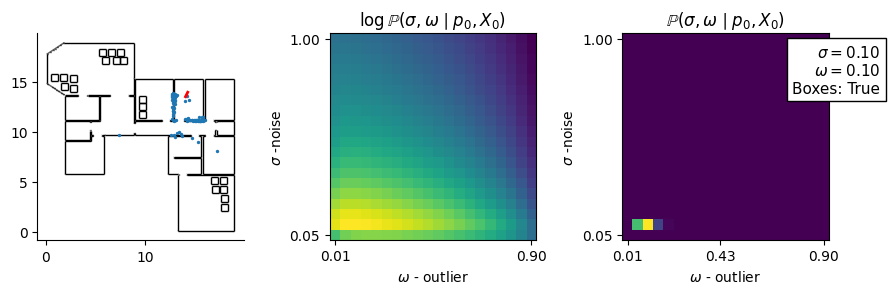

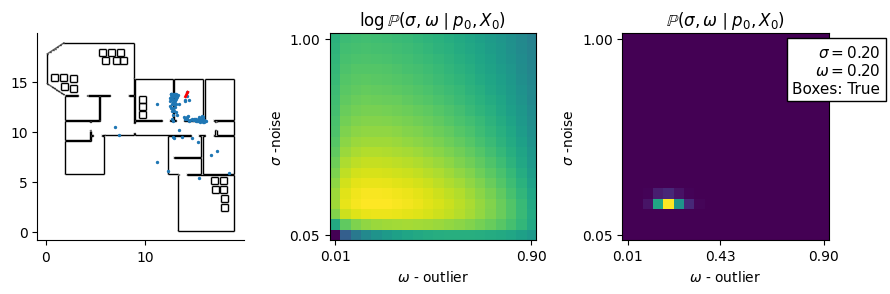

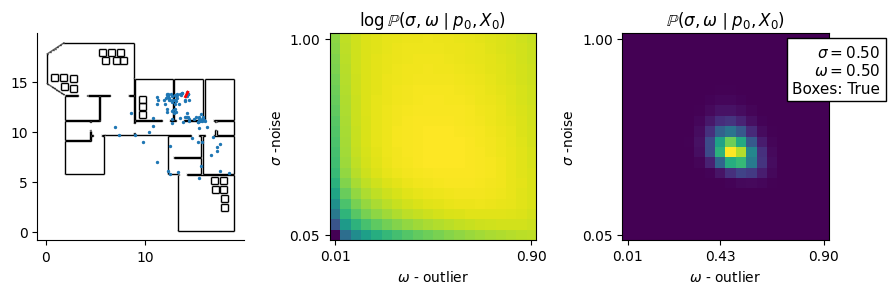

In [32]:
t0        = 4
use_boxes = True
for sig0, out0 in [(0.1,0.1),(0.2,0.2),(0.5,0.5)]:
    sensor_posterior_experiment(key, t0, sig0, out0, use_boxes)

## Part 2: MAP estimates for sensor parameters for perturbed poses

The full posterior is a function over a 5-dimensional space, so it can be hard to grasp &mdash; we are trying to in the demos at the end of the notebook where we visualize marginals. Here we try to collapse some information by using MAP estimates instead.


<hr style="height:2px">

**EXCERCISE**: 

Implement a function that takes a trace and perturbs its underlying position and heading based on
given noise levels.
```python
def perturb_pose(tr0, x_noise=1.0, hd_noise=10):

    # Your code
    # .....
    
    return tr1
```

Next, use your function to create `1000` perturbed traces and apply `sensor_MAP_estimate` from above. Once you did
that switch off the boxes and see if anything changes. Play with different noise levels as well.

<hr style="height:2px">

In [33]:
def pose_error(p, q):
    d = p - q
    d = d.at[2].set(adjust_angle(d[2]))
    return jnp.linalg.norm(d)

In [34]:
def _perturb_pose(key, tr, sig_x=0.1, sig_hd=5):
    keys = keysplit(key, 3)

    sig_hd = sig_hd/180*jnp.pi

    dx = genjax.tfp_normal(jnp.zeros(2), sig_x*jnp.ones(2)).sample(keys[0])
    dhd = genjax.normal(0.0, sig_hd).sample(keys[1])

    _, _, tr1, _ = tr.update(keys[2], choice_map({
        "x":  tr["x"]  +  dx,
        "hd": tr["hd"] + dhd
    }), argdiffs(tr.args))
    
    return tr1


perturb_pose = jit(vmap(lambda key, tr: _perturb_pose(key, tr, sig_x=.95, sig_hd=15), (0, None)))

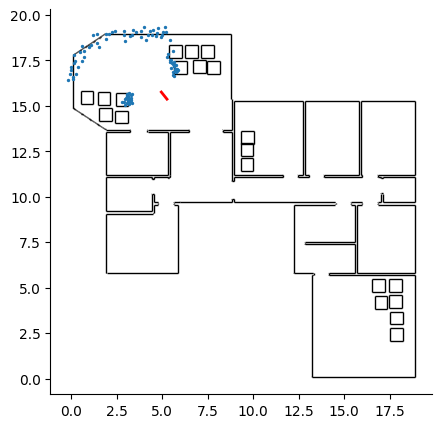

In [35]:
# Note: `t0=40` and `t0=35` are good choices
t0  = 40 
key = keysplit(key)
p0  = _ps[t0]
sig0 = 0.2
out0 = 0.0
tr0  = create_ground_truth(key, p0, sig0, out0, use_boxes=True)

# ====================
plot_tr(tr0, size=2)

In [36]:
key, keys = keysplit(key, 1, 1_000)

trs = perturb_pose(keys, tr0)
ps  = vmap(lambda tr: tr.retval[0])(trs)
err = vmap(lambda p: pose_error(p,p0))(ps)

# Make grid smaller so we don't get out of memory errors
shape  = (5,5)
bounds = ((0.05, 0.8), (1e-2, .9))

grid = get_linear_grid(shape, bounds, flat=True)
sigs = grid[...,0]
outs = grid[...,1]

# NOTE: Switch boxes on and off and see if anything changes
use_boxes = False

key = keysplit(key)
sigs_map, outs_map, scores = sensor_MAP_estimate(key, trs, sigs, outs, use_boxes)

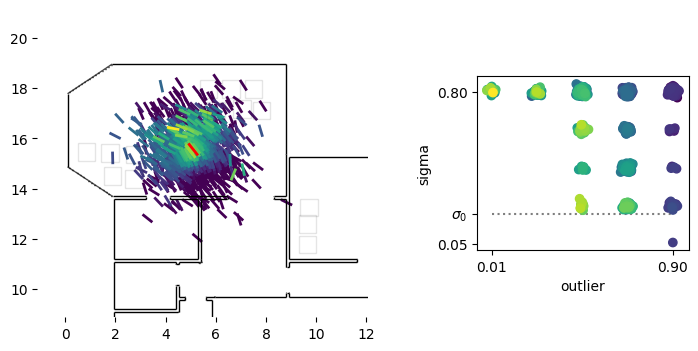

In [37]:
PAD = 3
quantile = 0.3

mask = scores>-jnp.inf
ps_  = ps[mask]
sc_  = scores[mask]

# =============================
fig, axs = plt.subplots(1, 2, figsize=(9,4), width_ratios=[2,1])

ax = axs[0]
ax.set_aspect(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
zoom_in(ps[:,:2], PAD, ax=ax)
plot_segs(_segs, c="k", zorder=1,ax=ax)
plot_segs(_boxes, c="k", zorder=1, ax=ax, alpha=0.1)
plot_poses(ps_, sc_, r=0.5, q=quantile, clip=-1e12, ax=ax)
plot_pose(p0, c="r", ax=ax)


ax = axs[1]

outs_map_ = outs_map + 0.01*np.random.randn(1_000)
sigs_map_ = sigs_map + 0.01*np.random.randn(1_000) 
order = jnp.argsort(scores)
ax.scatter(outs_map_[order], sigs_map_[order], c=scores[order], zorder=2)
ax.set(
        xlabel="outlier",
        xticks=outs[jnp.array([0, -1])], 
        xticklabels=[f"{v:0.2f}" for v in outs[jnp.array([0, -1])]],
        ylabel="sigma",
        yticks=[sigs[0], sig0, sigs[-1]], 
        yticklabels=[f"{sigs[0]:0.2f}", "$\sigma_0$",f"{sigs[-1]:0.2f}"],
)
ax.hlines(sig0, outs[0], outs[-1], color="k", linestyle=":", alpha=0.5, zorder=1)
ax.set_aspect(1)

<hr style="height:2px">

**Question**: 

Looking at the data above &mdash; you should take a second to understand what is plotted &mdash; how would you characterize the the true pose. What distinguishes it from other high scoring poses?

Below we provide two widgets to explore the posterior over poses and the full joint posterior over poses and sensor parameters, use those to investigate further.

<hr style="height:2px">

## Demos

In [38]:
def make_constraints(X, sensor_model_type="constrained"):
    """Return a choicemap with sensor constraints"""
    assert X.shape[-1] == 3
    
    X  = X[...,:3].reshape(-1,3)
    D  = jnp.linalg.norm(X, axis=-1)
    ch = genjax.choice_map({"X": 
            genjax.vector_choice_map({
                "measurement":  D if sensor_model_type == "constrained" else X
            }) 
    })
    return ch

In [39]:
def _eval_pose_and_sensor(tr, key, p, sig, outlier):
    ch = choice_map({
        'x':  p[:2], 
        'hd': adjust_angle(p[2]),
        'sig':     sig,
        'outlier': outlier,
    })
    diffs = argdiffs(tr.args)
    (_, w, tr_, _) = tr.update(key, ch, diffs)
    log_ps = get_data_logprobs(tr_)
    return tr_.get_score(), log_ps


eval_pose_and_sensor = jax.jit(jax.vmap(_eval_pose_and_sensor, in_axes=(None, None, 0, 0, 0)))
eval_pose = jax.jit(jax.vmap(_eval_pose_and_sensor, in_axes=(None, None, 0, None, None)))

### Pose Posterier: $\mathbb{P}(p \mid \sigma, \omega, X_0)$

In [40]:
# TODO: Convince me that this is actually faster.
@lru_cache(maxsize=None)
def make_inference_trace_sampler(w, zmax, sensor_model_type):
    model = make_model(w, zmax, sensor_model_type)
    importance = jit(model.importance)
    return importance

In [41]:
%matplotlib inline
from timeit import timeit
from ipywidgets import (interact, interactive, IntSlider, FloatSlider, HTMLMath, HTML,
        FloatRangeSlider, RadioButtons, Checkbox, Dropdown, Button, VBox, HBox, Output)
import warnings
warnings.filterwarnings('ignore')

button = Button(
                description='Save config',
                disabled=False, button_style='', # 'success', 'info', 'warning', 'danger' or ''
                icon='check' # (FontAwesome names without the `fa-` prefix)
        )


confs = []
vs    = None
sc    = None
shape = None
logps = None
tr0   = None
X0    = None


def func(t, sig0, out0, regenerate, inference_model_type, use_boxes, num_xy, num_hd, xs, ys, hds, sig, out, show_probs, quantile, PAD):

        def on_click(button):
                global confs;
                nonlocal t, sig0, out0, sig, out, use_boxes;
                conf = dict(t=t, sig0=sig0, out0=out0, sig=sig, out=out, use_boxes=use_boxes) 
                confs.append(conf)

        button.on_click(on_click)

        global key, tr0, X0;

        p0  = _ps[t]

        # Regenerate ground truth?
        if regenerate:
                key = keysplit(key)
                tr0 = create_ground_truth(key, p0, sig0, out0, use_boxes=True)
                _, X0  = tr0.get_retval()


        # Preparing a base trace for inference, i.e. one 
        # that we can call update on 
        w, zmax = 5, 10.0
        # %timeit -n 1 -r 1 make_inference_trace_sampler(w, zmax, inference_model_type)

        inference_model_importance = make_inference_trace_sampler(
                w, zmax, inference_model_type)

        ch            = make_constraints(X0, inference_model_type)
        ch["outlier"] = 0.1

        key = keysplit(key)
        _, tr = inference_model_importance(key, ch, (use_boxes,))


        # Create a vector grid
        shape       = (num_xy, num_xy, num_hd)
        grid_bounds = (xs + p0[0], ys + p0[1], hds + p0[2])
        vs          = get_linear_grid(shape, grid_bounds, flat=False)
        vs_flat     = vs.reshape(-1, len(shape))


        # Evaluate the Grid
        key = keysplit(key)
        # timed = timeit('eval_pose(tr, key, vs_flat[:,:3], sig, out);', globals=globals(), number=1)
        timed = timeit(lambda: eval_pose(tr, key, vs_flat[:,:3], sig, out), globals=globals(), number=1)
        key = keysplit(key)
        sc_flat, logps_flat = eval_pose(tr, key, vs_flat[:,:3], sig, out)
        sc = sc_flat.reshape(shape)
        logps = logps_flat.reshape(shape + (X0.shape[1],))

        ###############################
        ###############################
        ###############################
        ###############################
        fig, axs = plt.subplots(1,2, figsize=(12,7))

        ##
        ##  Ground Truth
        ##
        plot_tr(tr0, ax=axs[0])
        zoom_in(p0[:2], PAD, ax=axs[0])
        axs[0].set_title("Ground Truth\nfrom simulated world")


        ##
        ##  Posterior: Pose
        ##
        ax = axs[1]
        ax.text(0.05, 0.95, f"Num evals: {np.prod(shape)}\nGrid evaluation: {timed*1_000:4.2f} ms ", transform=axs[1].transAxes, fontsize=11,
                        verticalalignment='top', 
                        bbox=dict(facecolor='w', alpha=1.))

        if show_probs: ax.set_title("Posterior over poses\n$\mathbb{P}(p \mid \sigma, \omega, X_0)$")
        else: ax.set_title("Posterior over poses\n$\log \mathbb{P}(p \mid \sigma, \omega, X_0)$")
        ax.set_aspect(1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        zoom_in(p0[:2], PAD, ax=ax)
        plot_segs(_segs, c="k", zorder=1,ax=ax)
        if use_boxes: plot_segs(_boxes, c="k", zorder=1,ax=ax)

        sc_ = sc - logsumexp(sc)
        if show_probs: plot_poses(vs, jnp.exp(sc_), r=0.5, q=quantile, clip=-1e12, ax=ax)
        else: plot_poses(vs, sc_, r=0.5, q=quantile, clip=-1e12, ax=ax)

        fig.tight_layout()


widget = interactive(func,
        t = IntSlider(min=0, max=_T-1, step=1, value=35, continuous_update=False, description="Pose"),
        sig0 = FloatSlider(min=1e-6, max=1., step=0.01, value=1e-6, continuous_update=False, description='sigma'),
        out0 = FloatSlider(min=0.0, max=1., step=0.01, value=0.0, continuous_update=False, description='outlier'),
        regenerate  = Checkbox(value=True, description='Regenerate:',disabled=False),
        inference_model_type = Dropdown(options=["constrained", "baseline"],value="constrained",description='Model',disabled=False),
        use_boxes            = Checkbox(value=True, disabled=False, description='Use Boxes'),
        num_xy  = IntSlider(min=0, max=30, step=1, value=5, continuous_update=False, description='x, y'),
        num_hd  = IntSlider(min=0, max=30, step=1, value=5, continuous_update=False, description='hd'),
        xs   = FloatRangeSlider(min=-8.0, max=8.0, step=0.01, value=[-1.0,1.0], readout_format='.1f', continuous_update=False, description='x'),
        ys   = FloatRangeSlider(min=-8.0, max=8.0, step=0.01, value=[-1.0,1.0], readout_format='.1f', continuous_update=False, description='y'),
        hds  = FloatRangeSlider(min=-jnp.pi, max=jnp.pi, step=0.01, value=[-jnp.pi/4,jnp.pi/4], readout_format='.1f', continuous_update=False, description='hd'),
        sig  = FloatSlider(min=0.05, max=1., step=0.01, value=0.1, continuous_update=False, description='sigma'),
        out  = FloatSlider(min=0.0, max=1., step=0.01, value=0.1, continuous_update=False, description='outlier'),
        show_probs = Checkbox(value=False, disabled=False, description='Probability'),
        quantile = FloatSlider(min=0.0, max=1., step=0.01, value=0.0, continuous_update=False),
        PAD = FloatSlider(min=0.0, max=15., step=0.01, value=8.0, continuous_update=False),
)

ground_truth_children = widget.children[:4]
options_children      = widget.children[4:6]
grid_shape_children   = widget.children[6:8]
grid_entries_children = widget.children[8:13]
plot_children         = widget.children[13:16]

interactive_full_posterior = VBox([  
        HTML("<h1>Pose Posterior Explorer</h1>"),
        HBox([
                VBox([HTML("<h2>Ground Truth</h2>"), *ground_truth_children]),
                VBox([HTML("<h2>Plotting</h2>"), *plot_children]),
        ]),
        HBox([HTML("<h2>Grid Inference</h2>")]),
        HBox([*reversed(options_children)]),
        HBox([  
                VBox([HTML("<b>Grid Shape</b>"), *grid_shape_children]),
                VBox([HTML("<b>Grid Values</b>"), *grid_entries_children]),
        ]),
        widget.children[-1]
])  

interactive_full_posterior

<hr style="height:2px">

**EXCERCISE:**

Explore the posterior from Part 2.

<hr style="height:2px">

### Full posterior: $\mathbb{P}(p, \sigma, \omega \mid X_0)$

In [46]:
from timeit import timeit
from ipywidgets import (interact, interactive, IntSlider, FloatSlider, Label, HTML,
        FloatRangeSlider, RadioButtons, Checkbox, Dropdown, Button, VBox, HBox, Output)
import warnings
warnings.filterwarnings('ignore')

button = Button(
                description='Save config',
                disabled=False, button_style='', # 'success', 'info', 'warning', 'danger' or ''
                icon='check' # (FontAwesome names without the `fa-` prefix)
        )

confs = []
vs    = None
sc    = None
shape = None
logps = None
tr0   = None
X0    = None


def func(t, sig0, out0, regenerate, inference_model_type, use_boxes, num_xy, num_hd, num_sig, num_out, xs, ys, hds, sigs, outs,  show_probs, quantile, PAD):

        global key, tr0, X0;

        p0  = _ps[t]

        # Regenerate ground truth?
        if regenerate:
                key = keysplit(key)
                tr0 = create_ground_truth(key, p0, sig0, out0, use_boxes=True)
                _, X0  = tr0.get_retval()


        # Preparing a base trace for inference, i.e. one 
        # that we can call update on 
        w, zmax = 5, 10.0
        # %timeit -n 1 -r 1 make_inference_trace_sampler(w, zmax, inference_model_type)

        inference_model_importance = make_inference_trace_sampler(
                w, zmax, inference_model_type)


        ch            = make_constraints(X0, inference_model_type)
        ch["outlier"] = 0.1

        key = keysplit(key)
        _, tr = inference_model_importance(key, ch, (use_boxes,))


        # Create a vector grid
        shape       = (num_xy, num_xy, num_hd, num_sig, num_out)
        grid_bounds = (xs + p0[0], ys + p0[1], hds + p0[2], sigs, outs)
        vs          = get_linear_grid(shape, grid_bounds, flat=False)
        vs_flat     = vs.reshape(-1, len(shape))


        # Evaluate the Grid
        key = keysplit(key)
        timed = timeit(lambda: eval_pose_and_sensor(tr, key, vs_flat[:,:3], vs_flat[:,3], vs_flat[:,4]), globals=globals(), number=1)
        key = keysplit(key)
        sc_flat, logps_flat = eval_pose_and_sensor(tr, key, vs_flat[:,:3], vs_flat[:,3], vs_flat[:,4])
        sc = sc_flat.reshape(shape)
        logps = logps_flat.reshape(shape + (X0.shape[1],))


                
        sensor_marginal = logsumexp(sc, axis=(0,1,2))
        sensor_marginal = sensor_marginal - logsumexp(sensor_marginal)


        pose_marginal = logsumexp(sc, axis=(3,4))
        pose_marginal = pose_marginal - logsumexp(pose_marginal)

        ###############################
        ###############################
        ###############################
        fig, axs = plt.subplots(2,3, figsize=(12,8), height_ratios=[1,15], width_ratios=[5,5,2])
        for ax in axs[0,:]: ax.axis("off")

        ##
        ##  TEXT
        ##
        ax = axs[0,0]
        ax.text(0.05, 0.05, f"Num evals: {np.prod(shape)}\nGrid evaluation: {timed*1_000:4.2f} ms ", transform=ax.transAxes, fontsize=11,
                        verticalalignment='top', 
                        bbox=dict(facecolor='w', alpha=1.))

        ##
        ##  Ground Truth
        ##
        ax = axs[1,0]
        ax.set_title("Ground Truth\nfrom simulated world")
        plot_tr(tr0, ax=ax)
        zoom_in(p0[:2], PAD, ax=ax)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        

        ##
        ##  Marginal: Sensor Params
        ##
        ax = axs[1,2]
        if show_probs: ax.set_title("Marginalized posterior\nover sensor parameters\n$\mathbb{P}(\sigma, \omega \mid X_0)$")
        else: ax.set_title("Marginalized posterior\nover sensor parameters\n$\log \mathbb{P}(\sigma, \omega \mid X_0)$")
        ax.set(
                xlabel="outlier",
                xticks=[0, shape[4]-1], 
                xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
                ylabel="noise",
                yticks=[0, shape[3]-1], 
                yticklabels=[f"{v:0.4f}" for v in vs[0,0,0,[0, shape[3]-1],0,3]],
        )
        if show_probs: ax.imshow(jnp.exp(sensor_marginal), origin="lower")
        else: ax.imshow(sensor_marginal, origin="lower")

        ##
        ##  Marginal: Pose
        ##
        ax = axs[1,1]
        if show_probs: ax.set_title("Marginalized posterior\nover poses $\mathbb{P}(p \mid X_0)$")
        else: ax.set_title("Marginalized posterior\nover poses $\log \mathbb{P}(p \mid X_0)$")
        ax.set_aspect(1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        zoom_in(p0[:2], PAD, ax=ax)
        plot_segs(_segs, c="k", zorder=1, ax=ax)
        if use_boxes: plot_segs(_boxes, c="k", zorder=1, ax=ax)
        if show_probs: plot_poses(vs[:,:,:,0,0,:3], jnp.exp(pose_marginal), r=0.5, q=quantile, clip=-1e12, ax=ax)
        else: plot_poses(vs[:,:,:,0,0,:3], pose_marginal, r=0.5, q=quantile, clip=-1e12, ax=ax)

        fig.tight_layout()



widget = interactive(func,
        t    = IntSlider(min=0, max=_T-1, step=1, value=35, continuous_update=False, description="Pose"),
        sig0 = FloatSlider(min=1e-6, max=1., step=0.01, value=1e-6, continuous_update=False, description="Noise"),
        out0 = FloatSlider(min=0.0, max=1., step=0.01, value=0.0, continuous_update=False,   description="Outlier"),
        regenerate  = Checkbox(value=True, description='Regenerate',disabled=False),
        inference_model_type = Dropdown(options=["constrained", "baseline"], value="constrained", description='Model',disabled=False),
        use_boxes            = Checkbox(value=True,description='Use Boxes',disabled=False),
        num_xy  = IntSlider(min=1, max=10, step=1, value=5, continuous_update=False, description="x, y"),
        num_hd  = IntSlider(min=1, max=10, step=1, value=5, continuous_update=False, description="hd"),
        num_sig = IntSlider(min=1, max=10, step=1, value=5, continuous_update=False, description="sigma"),
        num_out = IntSlider(min=1, max=10, step=1, value=5, continuous_update=False, description="outlier"),
        xs   = FloatRangeSlider(min=-3.0, max=3.0, step=0.01, value=[-1.0,1.0], readout_format='.1f', continuous_update=False, description="x"),
        ys   = FloatRangeSlider(min=-3.0, max=3.0, step=0.01, value=[-1.0,1.0], readout_format='.1f', continuous_update=False, description="y"),
        hds  = FloatRangeSlider(min=-jnp.pi, max=jnp.pi, step=0.01, value=[-jnp.pi/4,jnp.pi/4], readout_format='.1f', continuous_update=False, description="hd"),
        sigs = FloatRangeSlider(min=1e-6, max=1.0, step=0.01, value=[0.01,0.7], readout_format='.1f', continuous_update=False, description="sigma"),
        outs = FloatRangeSlider(min=0.0,  max=1.0, step=0.01, value=[0.01,0.9], readout_format='.1f', continuous_update=False, description="outlier"),
        show_probs = Checkbox(value=False, description='Probability',disabled=False),
        quantile   = FloatSlider(min=0.0, max=1., step=0.01, value=0.0, continuous_update=False, description="Quantile"),
        PAD        = FloatSlider(min=0.0, max=15., step=0.01, value=8.0, continuous_update=False, description="Zoom"),
)


ground_truth_children = widget.children[:4]
options_children      = widget.children[4:6]
grid_shape_children   = widget.children[6:10]
grid_entries_children = widget.children[10:15]
plot_children         = widget.children[15:18]

interactive_full_posterior = VBox([  
        HTML("<h1>Full Posterior Explorer</h1>"),
        HBox([
                VBox([HTML("<h2>Ground Truth</h2>"), *ground_truth_children]),
                VBox([HTML("<h2>Plotting</h2>"), *plot_children]),
        ]),
        HBox([HTML("<h2>Grid Inference</h2>")]),
        HBox([*reversed(options_children)]),
        HBox([  
                VBox([HTML("<b>Grid Shape</b>"), *grid_shape_children]),
                VBox([HTML("<b>Grid Values</b>"), *grid_entries_children]),
        ]),
        widget.children[-1]
])  

interactive_full_posterior

<hr style="height:2px">

**EXCERCISE:**

Explore the posterior from Part 2.

**Q:** 

What is the quality of the posterior for different grid resolutions and sizes? 
What are ways to "constrain" a model to a particular noise level?

**Q:** 

How do we encode a preference for lower noise levels/ Tell the model to prefer lower noiselevels.

**Q:** Do you think that makes sense for outliers as well? Why? Why not?

<hr style="height:4px">

# Appendix

In [ ]:
#|  Let's look at what we just created. But keep in mind that going forward 
#|  we are forgetting about the 3D structure here. This is really just
#|  so we can take advantage of the performance of the 3D renderer.
v = Viewer(width=800, cam_pos=(*(_center - jnp.array([0,25])),20), cam_look=np.array([*_center,0]), background="#eee", view_as="world")
v.add_mesh(map_mesh.vertices, map_mesh.faces, c=np.array([.99,.99,.99]))
v.add_mesh(box_mesh.vertices, box_mesh.faces, c=np.array([.99,.1,.1]))
v.add_mesh(table.vertices, table.faces, c=np.array([1.,1.,1.]))
v

In [ ]:
@genjax.gen
def anchored_pose_prior(p, sig_x=0.5, sig_hd=10):
    
    sig_hd = sig_hd/180*jnp.pi

    x  = genjax.tfp_normal(p[:2], sig_x*jnp.ones(2)) @ "x"
    hd = genjax.tfp_normal(p[2], sig_hd)             @ "hd"

    q  = pack_2dpose(x, adjust_angle(hd))
    
    return q

In [ ]:
# TODO: Alternative version of the above model. Add excercise to change above model into this.
#       After looking at posterior over large area and realizing that it works reliably locally....
def make_anchored_model(w:int, zmax:float, sensor_model_type:str="constrained"):

    # Create a sensor model
    sensor_model = make_sensor_model(w, zmax, sensor_model_type)

    @gen
    def model(p:"Pose", sig:float, outlier:float, use_boxes=True):

        x  = diagnormal(p[:2], 0.5)      @ "x"
        hd = normal(p[2], 10/180*jnp.pi) @ "hd"
        p = pack_2dpose(x, hd)
        
        # Lift pose to 3D and 
        # render an image (deterministically)
        inds = jnp.where(use_boxes, jnp.array([0,1]), jnp.array([0]))
        Y    = render(lift_pose(p), inds)

        # Sample an image X conditioned on the rendered Y
        X, _ = sensor_model.inline(Y[:,:,:3], sig, outlier) 

        return p, X
    
    return model